This notebook implements and **simulates a 1D continuous attractor network** (two-ring architecture) to reproduce the qualitative behavior of **Fig. 4c–4d** in *Neupane, Fiete & Jazayeri (2024)*.

# From LM-GC Plasticity Model to CAN model of Grid cells
The Toy Plasticity Model was an auto-associative $1D$ model whose goal was to:
- Give the system a LM unit that is able to recognize periodicity and phase of landmarks
- Learns and represents the internal landmark phases matching external rhythm
- Generates internal landmark drive even when external signal is not visible

In other words, LM teaches the brain which internal module has the correct frequency and which phase in that model aligns with the external landmark, and after learning, LM can fire at the right times even without sensory landmarks.

### Given that an internal landmark signal exists, how does it shape the dynamics of a CAN and the variability of timing?
What we add here:
- A **Burak & Fiete–style CAN** (ring attractor) that supports **velocity-driven bump motion** (path integration).
- A **Neupane et al.–style internal-landmark “reset/correction” input** that can reduce drift/variance.

We'll be explicit about what comes from which model:

- **[BF09-like]**: Mexican-hat recurrent kernel on a ring + asymmetric shifts in the two populations + velocity gain that biases left vs right population.
- **[NFJ24 new]**: internal landmark inputs that are triggered *endogenously* at learned phases, with a temporally-shaped amplitude envelope.


The goal of this implementation is to show the effects of endogenous landmarks on **path integration** and **timing** and **simulate the post-learning scenario**.

In other words, **how learned endogenous landmarks interact with an existing CAN**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os, sys
from typing import Tuple
import importlib

## 0. CAN Model - Conceptual description
The CAN model is a **$1D$ continuous attractor network** that:

- forms and maintains a **localized activity bump** on a ring of neurons
- keeps the bump **stable** (preserves shape, only translates it around the ring)
- optionally receives **internal landmark inputs** at specific phases on the ring
- produces bump trajectories and reaction times (time to reach an end phase)

A canonical CAN: (all CANs??? what's the definition?)
- has neurons arranged on a *ring* ($1D$ circular manifold)
- has **translation invariant connectivity** (each neuron excites near neighbors inhibits far ones)
- supports a **stable bump of activity**:
    - a localized hill of firing that can move smoothly along the ring
- bump position $\leftrightarrow$ internal representation of a variable (eg. phase, time, location)


## Attractor bump activity pattern (phase)
With a DoG kernel + global drive, the ring settles into a **periodic activity pattern** (multiple peaks); the network state is best described as the **translation phase** of the entire pattern around the ring.

Tracking the position of the bump centers (peaks) in time is a way to model **path integration**: in the CAN, the whole pattern translates smothly along the ring according to a **noisy velocity input**.

Because the network exhibits a periodic multi-peak pattern, we define the network state as the position of the next activity peak ahead of the previously tracked one, following the procedure in Neupane et al. (2024). We detect local maxima in a forward window and select the first peak.”

- How does NFJ24 track the 'exact state', given that there are multiple peaks?
    - their code updates $\text{nn\_state}[t]$ using the **first peak ahead of last tracked location**
    - This implicitly defines 'state' as the location of a particular reference peak as it advances through the ring. seems valid because:
        - the whole periodic pattern shifts coherently
        - the ordering of the peaks around the ring is consistent
        - avoids confusion or mbiguity when peaks are similar in height
    - $\text{nn\_state}[t] \in \{0, \dots, K-1\}$

- This tracked $\text{nn\_state}$ is the **1D path-integrated variable** used for:
    - stopping the trial when the bump reaches an `end_phase`
    - triggering internal landmark inputs when the bump crosses learned landmark phases







## 1. Network architecture
We model a single module as an independent ring attractor.

- ### 1.1 Ring populations
    We simulate **two populations** (Left and Right), representing two directionally biased copies of the same $1D$ module, each with **K neurons** arranged on a ring.\
    The purpose is to implement **directional translation** of the activity pattern

    - $s(t) ∈ R^{2K}$: network state (activity), concatenated as $[s_L(t), s_R(t)]$
    - $s_L(t) ∈ R^{K}$: left ring activity
    - $s_R(t) ∈ R^{K}$: right ring activity


- ### 1.2 Mexican-hat connectivity matrix (Difference of Gaussians)
    We define a 1D lateral connectivity kernel on the ring

    $\text{MexHat}[k] = A_{\text{exc}}\exp(-s_{\text{exc}}z^2_k) - A_{\text{inh}}\exp(-s_{\text{inh}}z^2_k)$

    - $z_k \in \{-\frac{K}{2}, \dots, \frac{K}{2}-1\}$ is the circular distance
    - $A_{\text{exc}}$, $A_{\text{inh}}$ are amplitudes
    - $s_{\text{exc}}$, $s_{\text{inh}}$ are control widths

    This kernel has:
    - local excitation (narrow Gaussian)
    - broader inhibition (larger Gaussian)

    It ensures a **single stable pattern of bumps** and is built such that **neighbours excite neighbours**:
    - Neurons near bump center must excite each other to maintain bump height
    - Neurons far away must inhibit each other to prevent multiple bumps from appearing

- ### 1.3 Directionally biased synapses

    We build four $K \times K$ weight matrices such that each row $i$ defines **incoming** weights onto neuron $i$, depending on the interacting type of populations:
    - **2 Directional**: they create a **bump drift** (clockwise for right direction, counterclockwise for left)
        - $W_{RR}$: $R \leftarrow R$, shifted by $-1$
        - $W_{LL}$: $L \leftarrow L$, shifted by $+1$

    - 2 coupling the two populations: enforce a single bump is shared between L and R
        - $W_{RL}$: $R \leftarrow L$ (unshifted weight)
        - $W_{LR}$: $L \leftarrow R$ (unshifted)
    
    

**Why this architecture produces a moving bump**:
This makes the model a continuous attractor network with **direction selectivity** $\mapsto$ (L -> L weights shifted one way / R->R weights shifted the other way makes a stable pattern that moves when you bias a population relative to the other)

## From BF09 to NFJ24:
- According to Burak & Fiete ring attractor: **kernel + shifted weights + velocity gain + low-pass update**
    - Two coupled populations with slightly different recurrent connectivity (purpose: *directional motion)*
    - Recurrent Mexican-hat connectivity stabilizes a single pattern of activity
    - Oppositely shifted recurrent weights: make the stable pattern move when you bias a population relative to the other
    - Velocity modulation can amplify one population's activity and suppress the other $\rightarrow$ the bump pattern translates in a controlled direction in response to velocity
    - Low-pass dynamics smooth the motion + ReLU
    
- NFJ24 becomes:
    - Learning of internal landmark (LM-GC plasticity model)
    - Additional internal landmark input $I_\text{int}$ to the CAN during simulation
        - transient
        - phase-specific
        - learned from the plasticity model
    - Time envelope for landmark-triggered input: choice to implement a *kick / reset* effect
    - Velocity tuning procedures to match behavioral timing


## 2. Parameters

- ### Initialization parameters:

    Initiate class CAN_Network using structural parameters, which follow *Burak & Fiete (2009)*
    - $K$: (364) number of ring neurons in a population

    - Numerics: 
        - $dt$: step size of numerical integration (s)
        - $\tau_s$: synaptic time constant (s)

    - Drive    
        - $\beta_{\text{vel}}$: gain on velocity input (controls how strongly the bump moves per unit velocity)
        - $\beta_0$: global feedforward excitatory drive amplitude (sets how excitable the network is)
    
    - mexhat: built using connectivity shape parameters: 
        - $A_{\text{exc}}$, $A_{\text{inh}}$ 
        - $s_{\text{exc}}$, $s_{\text{inh}}$

- ### Task-specific parameters:
    - baseline speeds used to compute velocity input $v(t)$, which is a noisy velocity input that is computed then kept constant per-trial
        - $\text{wolm\_speed}$: without internal landmarks
        - $\text{wlm\_speed}$: with internal landmarks
    - $\text{wm}$: Weber fraction controlling speed noise

    - $\text{landmark\_input\_loc}$: array of neuron indices indicating the phases at which endogenous landmarks are stored


*RK)* the paper doesn't go parameter-by-parameter with biological justification. They say that the CAN was adapted from *Burak & Fiete* + they did grid searches over velocity to match the behavioral periodicity and ensure robustness across Weber fractions

Eg. $\beta_{\text{vel}}$ was calibrated so that with the chosen speeds $\text{wolm}$ $\text{wlm}$ the model reproduces the $\sim 0.65s$ periodicity and matched mean time to target

# 3. CAN Simulation

It assumes a full CANNetwork with attributes $K$, $dt$, $\tau_s$, $\beta_\text{vel}$, $\beta_0$, $FF_\text{global}$, $W_\text{RR}$, $W_\text{LL}$, $W_\text{RL}$, $W_\text{LR}$.

At time step $t$ we compute:
- One **noisy velocity sample** per trial and keep it constant over time: $v(t)= v_\text{base} + v_\text{noise}$
    - with landmarks $\rightarrow$ $v_\text{base} = \text{wlm\_speed}$
    - without landmarks $\rightarrow$ $v_\text{base} = \text{wolm\_speed}$
- Left ring and right ring activity $s_L$, $s_R$ 
- **Velocity gains**:
    - $v_L = 1 - \beta_{\text{vel}} * v(t)$
    -  $v_L = 1 + \beta_{\text{vel}} * v(t)$
    - modulate how strongly the recurrent input moves the bump left / right
- **Recurrent input** (vectors in $\mathbb{R}^K$)
    - $g_{\text{LR}} = <W_{LR}, s_R>$,   $g_\text{LL} = <W_{LL}, s_L>$
    - $g_{\text{RR}} = <W_{RR}, s_R>$,   $g_\text{RL} = <W_{RL}, s_L>$
    - represent how neurons from either population excite each others (e.g. how R neurons influence L and viceversa for all combinations)
- **Pre-activation currents**
    - $G = [G_L, G_R]$  
    - $G_L$: $v_L \times (g_{LL} + g_{LR} + FF_{\text{global}}) + \text{lm\_input}$,
        - total contribution into the left ring neurons 
    - $G_R$: $v_R \times (g_{RL} + g_{RR} + FF_{\text{global}}) + \text{lm\_input}$,
        - 'into-right direction contribution'
- **Activation / firing rate**  
    - $F = \text{ReLU(G)}$
    - Burak & Fiete use a threshold-linear (ReLU) activation
- **Euler step**
    - $s(t) = s(t-1) + (F - s(t-1)) * dt / \tau_s$
    - synaptic low-pass update


## 4. Algorithms

### 4.1 Initialization [BF09-like + small static bump]
Goal: let the ring settle into a stable bump attractor.

**Algorithm**
1. Create a small noisy velocity input (constant over the init block).
2. Add a weak static Gaussian “seed” input at a chosen ring location (just to pick a phase).
3. Integrate the CAN dynamics for $T_\text{init} = 10$ seconds.
4. Return the final state $s_\text{init} ∈ R^{2K}$, which will be the initial condition for the actual simulation.

    It is a $10s$ dynamics that is not modeling sensory landmarks, but it is stabilizing the network into a proper attractor bump before the task begins.
    - No task stimuli
    - No learned landmarks
    - No external cues
    - Just initialize the bump attractor to a stable state

**Biological interpretation**: In the brain, grid-cell attractor dynamics don’t start from random noise at the beginning of every trial — they are already in a stable state from previous activity. 

The “landmark” here is just a weak Gaussian to ensure the bump starts somewhere predictable.

### 4.2 Trial simulation  [BF09-like + optional NFJ24 landmark resets]
Goal: simulate one timing/path-integration trial.

**Algorithm**
1. Initialize initial network activity $s[:,0] = s_\text{init}$.
2. Draw one noisy scalar velocity $v$ for the whole trial (using Weber noise).
3. For each timestep $t$:
  - compute recurrent inputs and pre-activation currents
  - if internal landmarks are enabled:
    - check which landmark phase has been passed
    - if it is the first entry, store entry time in the 'landmark region'
    - compute a time-envelope amplitude $\text{amp}(\text{dt\_steps})$ (Gaussian in time since entry)
    - inject Gaussian bump x internal landmark input
      - internal landmark input uses centers = ALL landmark locations (sum of Gaussians)
  - apply ReLU and low-pass update
  - track the bump center via a local-maximum search around the previous center
4. Stop when the bump phase reaches the stopping threshold.

Outputs per trial:
- $\text{nn\_state}(t)$: trajectory
- trial duration / reaction time $\text{RT} = (\#\text{ steps})*dt$
- optional state matrix $s$ for debugging/visualization


- ### During run_trial (CAN model)
    - The subject performs the internal timing task.
    - Landmarks do not correspond to external stimuli (there are no external cues in the reproduction phase)
    - Only internal landmark triggers (if landmarkpresent=True), and they are triggered by the bump reaching certain internal phases.
    - These internal triggers reduce drift variance and explain the periodicity seen in behavior.


In [ ]:
path_CAN = os.path.abspath("..")
path_PM = os.getcwd().replace('CAN', 'Plasticity_Model')
print("CWD:", os.getcwd())
print("plast mod wd:", path_PM)
sys.path.insert(0, path_CAN)
sys.path.insert(0, path_PM)

CWD: /Users/clara/Desktop/MAI/Anno 2/Sem 1/Neuro/Neupane Project/mental-navigation/src/mental_navigation/CAN
plast mod wd: /Users/clara/Desktop/MAI/Anno 2/Sem 1/Neuro/Neupane Project/mental-navigation/src/mental_navigation/Plasticity_Model


In [ ]:
from CAN.CAN_network import CANNetwork
from CAN.CAN_simulator import CANSimulator
from Plasticity_Model.lmgc_plast_model import LMGCPlasticityModel
from Plasticity_Model.model_units import ECModule, LandmarkUnit

We simulate a run mirroring the parameters chosen by the authors:

In [ ]:
K = 364
net = CANNetwork(K = K)
sim = CANSimulator(net)

We introduce a helper conversion between indices $(0, \dots, K-1)$ and degrees $(0, 360)$

In [ ]:
def idx_to_deg(idx, K):
    return (np.asarray(idx) * 360.0) / K

def deg_to_idx(deg, K):
    return (np.asarray(deg) * K) / 360.0


print("Index 0 -> deg:", idx_to_deg(0, K))
print("Deg 180 -> idx:", deg_to_idx(180, K))


Index 0 -> deg: 0.0
Deg 180 -> idx: 182.0


## MexHat

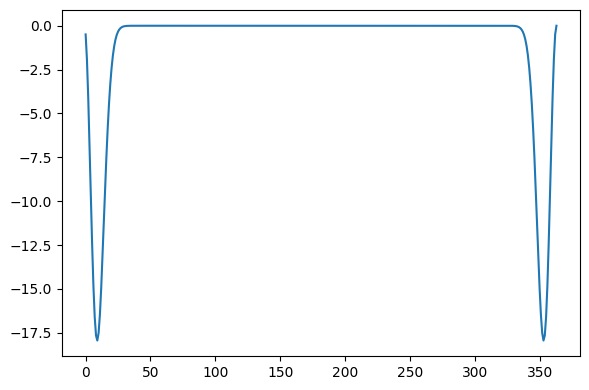

In [ ]:
mexhat = net.mexhat
plt.figure(figsize = (6,4))
plt.plot(mexhat)
plt.tight_layout()
plt.show()

## Landmark input profile

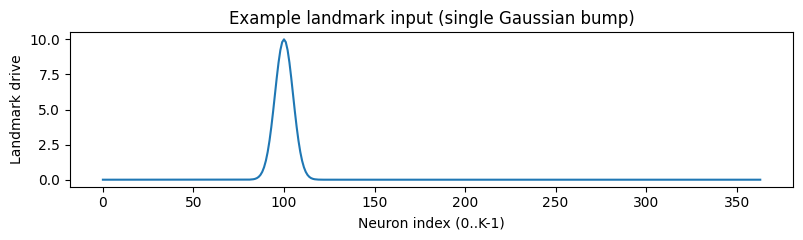

In [ ]:
lm = sim.bump_for_initialization(lm_center = 100, lm_std=5.0, lm_gain=10.0)

plt.figure(figsize=(8,2.5))
plt.plot(np.arange(K), lm)
plt.title("Example landmark input (single Gaussian bump)")
plt.xlabel("Neuron index (0..K-1)")
plt.ylabel("Landmark drive")
plt.tight_layout()
plt.show()

## Initialization to a stable pattern
Run $\text{init\_state}()$ to verify it leads to a periodic activity, and multiple peaks exist and are stable

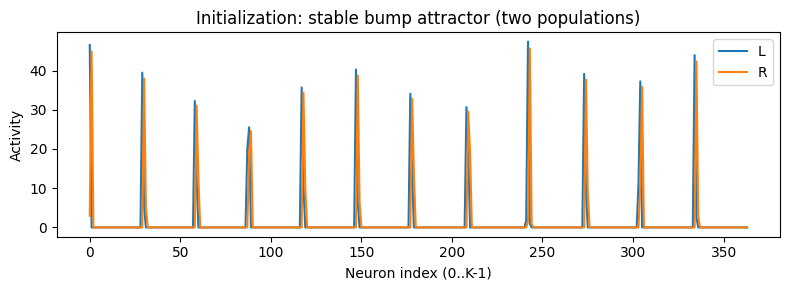

Peak idx L: 242 Peak idx R: 243


In [ ]:
init = sim.init_state(T=10)

plt.figure(figsize=(8,3))
plt.plot(np.arange(K), init[:K], label="L")
plt.plot(np.arange(K), init[K:], label="R")
plt.title("Initialization: stable bump attractor (two populations)")
plt.xlabel("Neuron index (0..K-1)")
plt.ylabel("Activity")
plt.legend()
plt.tight_layout()
plt.show()

print("Peak idx L:", int(np.argmax(init[:K])), "Peak idx R:", int(np.argmax(init[K:])))


Verify periodicity and stability: peaks are quite close in value and are approximarely 30 neurons away from each other

In [ ]:
def find_n_peaks(s, n):
    d = {}
    ring = s.copy()
    for i in range(n):
        peak_idx = np.argmax(ring)
        #print(peak_idx, s[peak_idx])
        d[peak_idx] = ring[peak_idx]
        ring[peak_idx] = 0
    
    return d


In [ ]:
s_L = init[:K].copy()
peaks = find_n_peaks(s_L, 12)
p = sorted(peaks.keys())
[np.abs(p[i]-p[i+1]) for i in range(0, 11)]

[np.int64(29),
 np.int64(29),
 np.int64(30),
 np.int64(29),
 np.int64(30),
 np.int64(30),
 np.int64(31),
 np.int64(34),
 np.int64(31),
 np.int64(31),
 np.int64(30)]

In [ ]:
sorted(peaks)

[np.int64(0),
 np.int64(29),
 np.int64(58),
 np.int64(88),
 np.int64(117),
 np.int64(147),
 np.int64(177),
 np.int64(208),
 np.int64(242),
 np.int64(273),
 np.int64(304),
 np.int64(334)]

## Trial simulation

In [ ]:
trial = sim.run_trial(init_condition = init)

AttributeError: 'CANSimulator' object has no attribute 'net'

In [13]:
trial

{'s': array([[3.45016650e+001, 3.43230812e+001, 3.41474756e+001, ...,
         7.76467794e-038, 7.66761946e-038, 7.57177422e-038],
        [1.18249029e-109, 1.16770916e-109, 1.15311280e-109, ...,
         7.87251938e-037, 7.77411289e-037, 7.67693648e-037],
        [1.01833371e-109, 1.00560454e-109, 9.93034484e-110, ...,
         7.97416740e-036, 7.87449031e-036, 7.77605918e-036],
        ...,
        [3.02068471e-109, 2.98292615e-109, 2.94563958e-109, ...,
         3.32817071e+001, 3.35530805e+001, 3.38241224e+001],
        [5.32940535e-108, 5.26278778e-108, 5.19700293e-108, ...,
         1.79881752e-040, 1.77633230e-040, 1.75412815e-040],
        [2.78749833e-033, 2.75265460e-033, 2.71824642e-033, ...,
         1.82945159e-039, 1.80658344e-039, 1.78400115e-039]],
       shape=(728, 71389)),
 'nn_state': array([ 30,  30,  30, ..., 359, 359, 360], shape=(71389,)),
 'phase_unw': array([ 30.,  30.,  30., ..., 359., 359., 360.], shape=(71389,)),
 'lm_amplitude': array([0.00000000e+00, 0.00

In [14]:
print(trial['s'].shape)
trial['nn_state'].shape

(728, 71389)


(71389,)

## Wrapped case

$\text{trial}[\text{"nn\_state"}]$ is the wrapped index $0, \dots, K-1$ of *which peak* we are tracking on the ring

We try tracking a discrete peak of a periodic spatial pattern that is translating

In [15]:
#np.arange(trial_nolm['nn_state'].shape[0])
#71632
int(trial_nolm['nn_state'].shape[0] * net.dt + 1)

NameError: name 'trial_nolm' is not defined

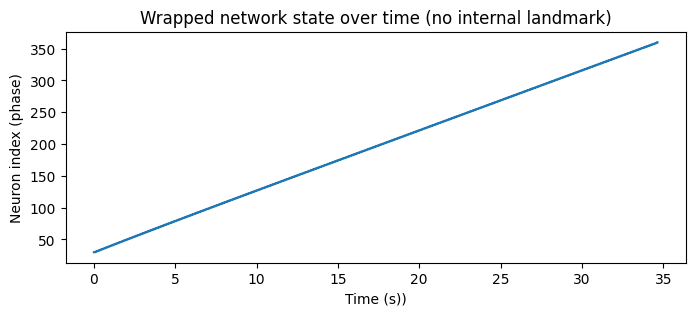

In [17]:
trial_nolm = sim.run_trial(
    init_condition = init, landmarkpresent=False,
    #
    )
plt.figure(figsize=(8,3))
plt.plot(np.arange(len(trial_nolm['nn_state'])) * net.dt, trial_nolm['nn_state'], label="L")
nr_steps = trial_nolm.get('s').shape[1]

plt.xlabel("Time (s))")
plt.ylabel("Neuron index (phase)")
plt.title("Wrapped network state over time (no internal landmark)")
plt.show()

Without landmarks, the CAN supports a translating periodic activity pattern whose phase advances continuously under velocity input. Noise and discretization cause small trial-to-trial variability, producing a thick diagonal band when plotting wrapped peak indices.

Here we observe the position of the 'next peak ahead' sampled at discrete time steps, which already implies discretization (quantization) and small variability even in constant velocity.

The periodic pattern is not perfectly rigid, as peak heights fluctuate, spacing is not perfctly uniform.

Local interactions and nonlinearity may distort the pattern and sometimes it may happen that a peak is detected slightly earlier or later, or there is some ambiguity between two consecutive peaks. It looks like a thick band, and even with perfectly constant velocity, the time at which we cross a peak depend on noise and amplitude, so peak transitions do not occur exactly at the same step. The slope is given by the noise term of the velocity. 

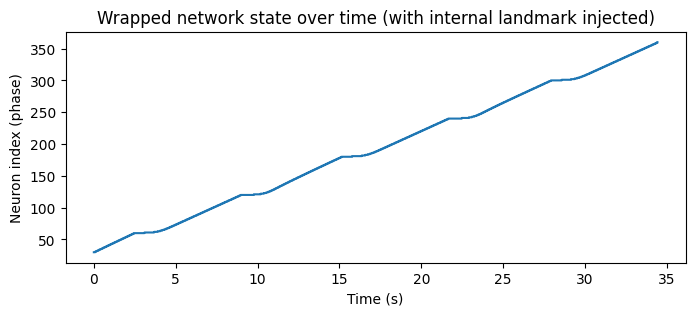

In [16]:
trial_lm = sim.run_trial(init_condition = init, landmark_input_loc=(60, 120, 180, 240, 300))
plt.figure(figsize=(8,3))
plt.plot(np.arange(len(trial_lm['nn_state'])) * net.dt, trial_lm['nn_state'], label="L")
plt.xlabel("Time (s)")
plt.ylabel("Neuron index (phase)")
plt.title("Wrapped network state over time (with internal landmark injected)")
plt.show()

A flat region orr with very shallow slope represents time steps where the translation of the pattern has slowed down or almost stopped.

We can qualitatively see that, since only the LM condition shows flat regions, landmark injection is likely the cause of this behavior.

We interpret this with the intuition that with internal landmarks, transient excitatory inputs injected at specific phases stabilize the pattern and transiently suppress translation, producing plateaus in the unwrapped phase trajectory. These plateaus correspond to endogenous landmark “resets” and lead to reduced accumulation of variability over time.

In this plot, a region can stay flat either because the phase is not changing much, or because there is an almost complete *wrap* around the cycle. In this wrapped-up case it is not easy to disambiguate this.

We can inspect velocity gains and ladmark amplitude during flat areas.
During flat regions with landmarks we expect:
- high landmark amplitude
- velocity drive suppressed by external input
- translation stalls

In [17]:
trial_lm

{'s': array([[3.26719405e+001, 3.25008880e+001, 3.23310217e+001, ...,
         2.75452876e-037, 2.72009715e-037, 2.68609594e-037],
        [1.34267279e+001, 1.33564360e+001, 1.32895050e+001, ...,
         2.73691443e-036, 2.70270300e-036, 2.66891922e-036],
        [4.19757456e-109, 4.14510488e-109, 4.09329107e-109, ...,
         2.71641425e-035, 2.68245908e-035, 2.64892834e-035],
        ...,
        [9.39478587e-110, 9.27735105e-110, 9.16138416e-110, ...,
         3.32811349e+001, 3.35557714e+001, 3.38300707e+001],
        [1.07197450e-109, 1.05857482e-109, 1.04534263e-109, ...,
         6.86037652e-040, 6.77462181e-040, 6.68993904e-040],
        [2.23962213e-109, 2.21162686e-109, 2.18398152e-109, ...,
         6.83969970e-039, 6.75420345e-039, 6.66977591e-039]],
       shape=(728, 71768)),
 'nn_state': array([ 30,  30,  30, ..., 359, 359, 360], shape=(71768,)),
 'phase_unw': array([ 30.,  30.,  30., ..., 359., 359., 360.], shape=(71768,)),
 'lm_amplitude': array([0.00000000e+00, 0.00

In [ ]:
#np.arange(len(trial["phase_unw"])) * net.dt

array([0.00000e+00, 5.00000e-04, 1.00000e-03, ..., 3.58145e+01,
       3.58150e+01, 3.58155e+01], shape=(71632,))

## Unwrapped case (single trial) + landmark amplitude

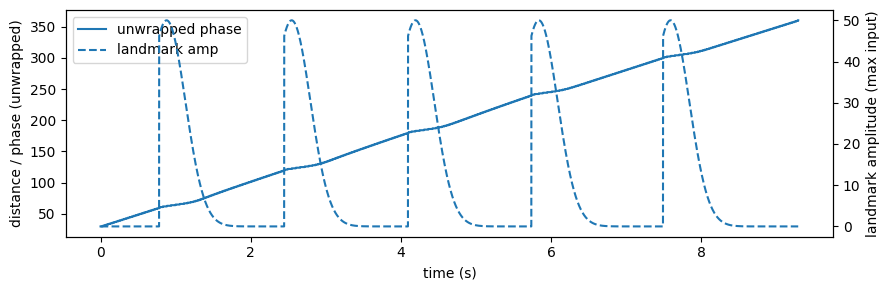

In [25]:
K = 364
net = CANNetwork(K = K)
sim = CANSimulator(net)
init = sim.init_state(T=10)


trial = sim.run_trial(init_condition=init, landmarkpresent=True, wm=0.08, landmark_onset_steps = 200, landmark_tau_steps = 500)

t = np.arange(len(trial["phase_unw"])) * net.dt


fig, ax1 = plt.subplots(figsize=(9,3))

ax1.plot(t, trial["phase_unw"], label="unwrapped phase")
ax1.set_xlabel("time (s)")
ax1.set_ylabel("distance / phase (unwrapped)")

ax2 = ax1.twinx()
ax2.plot(t, trial["lm_amplitude"], linestyle="--", label="landmark amp")
ax2.set_ylabel("landmark amplitude (max input)")

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1+lines2, labels1+labels2, loc="upper left")

plt.tight_layout()
plt.show()

if landmarks are effectively doing anything, then we expect to see a plateau where the landmark amplitude reaches its peak

# Simulate Fig 4.c

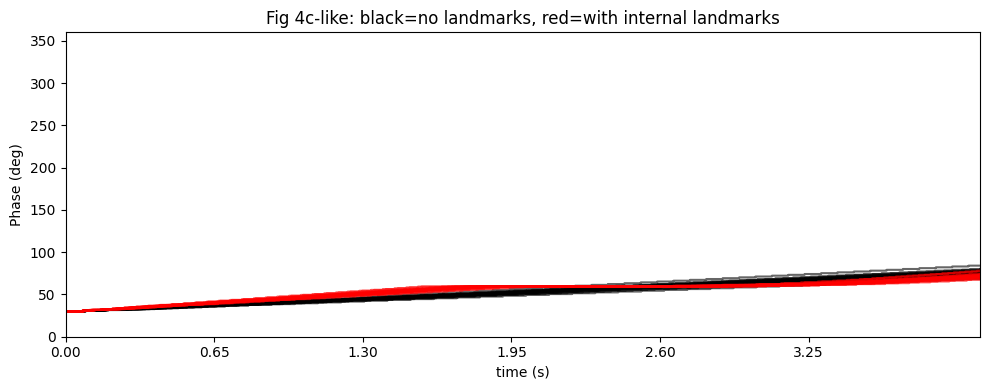

In [24]:
def run_many_trials(sim, init_condition, n_trials, landmarkpresent, **kwargs):
    out = []
    for _ in range(n_trials):
        out.append(sim.run_trial(init_condition=init_condition, landmarkpresent=landmarkpresent, **kwargs))
    return out

params = dict(
    initial_phase=30.0,
    end_phase=360.0,
    landmark_input_loc=(60,120,180,240,300),
    wolm_speed=0.45,
    wlm_speed=0.65,
    wm=0.08,
    T_max=10.0,
)

tr_no = run_many_trials(sim, init, n_trials=20, landmarkpresent=False, **params)
tr_lm = run_many_trials(sim, init, n_trials=20, landmarkpresent=True,  **params)

plt.figure(figsize=(10,4))

for tr in tr_no:
    t = np.arange(len(tr["phase_unw"])) * net.dt
    phase_deg = tr["phase_unw"] * (360.0 / K)
    plt.plot(t, phase_deg, color="black", alpha=0.6)

for tr in tr_lm:
    t = np.arange(len(tr["phase_unw"])) * net.dt
    phase_deg = tr["phase_unw"] * (360.0 / K)
    plt.plot(t, phase_deg, color="red", alpha=0.6)

plt.xlabel("time (s)")
plt.ylabel("Phase (deg)")
plt.ylim(0, 360)
plt.xlim(0, 4)
plt.title("Fig 4c-like: black=no landmarks, red=with internal landmarks")

base = 0.65
ticks = np.arange(0, 5*base + 1e-9, base)  # 0..3.25
plt.xticks(ticks, [f"{x:.2f}" for x in ticks])
plt.tight_layout()
plt.show()


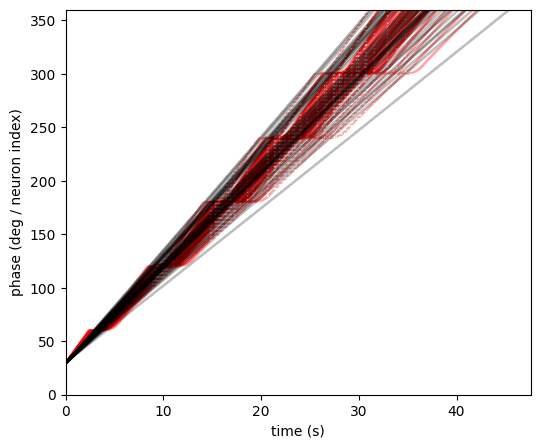

In [41]:
num_sim = 50
lm_locs = np.arange(60, 301, 60)  
initial_phase = 30
end_phase = 360

wm = 0.08
wolm_speed = 0.35
wlm_speed  = 0.42

fig, ax = plt.subplots(figsize=(6, 5))

# WITH internal landmarks (red)
for _ in range(num_sim):
    out = sim.run_trial(init_condition=init,
                        initial_phase=initial_phase,
                        end_phase=end_phase,
                        landmarkpresent=True,
                        landmark_input_loc=lm_locs,
                        wolm_speed=wolm_speed,
                        wlm_speed=wlm_speed,
                        wm=wm)

    t = np.arange(len(out["phase_unw"])) * net.dt
    ax.plot(t, out["phase_unw"], alpha=0.35, color = 'red')

    # dotted reset lines (peak of LM envelope)
    lm_entry = out.get("lm_entry_times", None)
    if lm_entry is not None:
        reset_steps = lm_entry + 500  # landmark_onset_steps default=500
        reset_steps = reset_steps[~np.isnan(reset_steps)].astype(int)
        for rs in reset_steps:
            ax.axvline(rs * net.dt, linestyle=":", linewidth=1, color = 'white')

# WITHOUT landmarks (black)
for _ in range(num_sim):
    out = sim.run_trial(init_condition=init,
                        initial_phase=initial_phase,
                        end_phase=end_phase,
                        landmarkpresent=False,
                        landmark_input_loc=lm_locs,
                        wolm_speed=wolm_speed,
                        wlm_speed=wlm_speed,
                        wm=wm)
    t = np.arange(len(out["phase_unw"])) * net.dt
    ax.plot(t, out["phase_unw"], alpha=0.25, color = 'black')

ax.set_xlabel("time (s)")
ax.set_ylabel("phase (deg / neuron index)")
#ax.set_xlim(0, 4)
ax.set_xlim(left = 0)
ax.set_ylim(0, 360)
plt.show()

Note that the behavior seems to match the result of fig 4.c, since there exists some periodic 'plateau' acting as a reset when stored internal landmarks are present and are injected in the network.

However, with the current parameters taken as a baseline from NFJ24, the network takes approximately $5s$ to reach a landmark, while in the real task landmarks are shown with a periodicity of $0.65s$. The time needed to hit each of the landmarks depends on the drift speed and, if it lower, the path integration is going to be slower too.

So the next step is to do a grid search over velocities, as the authors of the paper did in their research, to tune $\text{wolm}_\text{speed}$ and $\text{wlm}

In [18]:
def plot_fig4c(
    net,
    sim,
    num_sim,
    init, initial_phase, end_phase,
    landmark_input_loc,
    wolm_speed, wlm_speed, wm
):
    fig, ax = plt.subplots(figsize=(6, 5))

    # WITHOUT landmarks (black)
    for _ in range(num_sim):
        out = sim.run_trial(init_condition=init,
                            initial_phase=initial_phase,
                            end_phase=end_phase,
                            landmarkpresent=False,
                            landmark_input_loc=lm_locs,
                            wolm_speed=wolm_speed,
                            wlm_speed=wlm_speed,
                            wm=wm)
        t = np.arange(len(out["nn_state"])) * net.dt
        ax.plot(t, out["nn_state"], alpha=0.25, color = 'black')
    
    # WITH internal landmarks (red)
    reset_times_all = []
    for _ in range(num_sim):
        out = sim.run_trial(init_condition=init,
                            initial_phase=initial_phase,
                            end_phase=end_phase,
                            landmarkpresent=True,
                            landmark_input_loc=lm_locs,
                            wolm_speed=wolm_speed,
                            wlm_speed=wlm_speed,
                            wm=wm,
                            #landmark_onset_steps = 200,
                            #landmark_tau_steps = 150)
        )
        t = np.arange(len(out["nn_state"])) * net.dt
        ax.plot(t, out["nn_state"], alpha=0.25, color="red")


    for y in landmark_input_loc:
        ax.axhline(y, linestyle="--", linewidth=1, color="white", alpha=0.8)

    ax.set_xlabel("time (s)")
    ax.set_ylabel("phase (deg / neuron index)")
    ax.set_xlim(left=0)
    ax.set_ylim(0, 360)
    plt.show()




"""

    t = np.arange(len(out["phase_unw"])) * net.dt
        ax.plot(t, out["phase_unw"], alpha=0.35, color = 'red')

        # dotted reset lines (peak of LM envelope)
        lm_entry = out.get("lm_entry_times", None)
        if lm_entry is not None:
            reset_steps = lm_entry + 500  # landmark_onset_steps default=500
            reset_steps = reset_steps[~np.isnan(reset_steps)].astype(int)
            for rs in reset_steps:
                ax.axvline(rs * net.dt, linestyle=":", linewidth=1, color = 'white')

    ax.set_xlabel("time (s)")
    ax.set_ylabel("phase (deg / neuron index)")
    #ax.set_xlim(0, 4)
    ax.set_xlim(left = 0)
    ax.set_ylim(0, 360)
    plt.show()
"""

    

'\n\n    t = np.arange(len(out["phase_unw"])) * net.dt\n        ax.plot(t, out["phase_unw"], alpha=0.35, color = \'red\')\n\n        # dotted reset lines (peak of LM envelope)\n        lm_entry = out.get("lm_entry_times", None)\n        if lm_entry is not None:\n            reset_steps = lm_entry + 500  # landmark_onset_steps default=500\n            reset_steps = reset_steps[~np.isnan(reset_steps)].astype(int)\n            for rs in reset_steps:\n                ax.axvline(rs * net.dt, linestyle=":", linewidth=1, color = \'white\')\n\n    ax.set_xlabel("time (s)")\n    ax.set_ylabel("phase (deg / neuron index)")\n    #ax.set_xlim(0, 4)\n    ax.set_xlim(left = 0)\n    ax.set_ylim(0, 360)\n    plt.show()\n'

## Run with different wm

In [19]:
num_sim = 50
lm_locs = np.arange(60, 301, 60)  
initial_phase = 30
end_phase = 360

K = 364
net = CANNetwork(K = K)
sim = CANSimulator(net)
init = sim.init_state(T=10)

wm = 0.08

# Baseline 
wolm_speed = 0.35
wlm_speed  = 0.42

# try faster
# no landmark: v=0.45 -> T=27.126s
# with landmark: v=0.65 -> T=27.139s
wolm_speed = 0.45
wlm_speed = 0.65


trial_lm = sim.run_trial(init_condition=init,
                            initial_phase=initial_phase,
                            end_phase=end_phase,
                            landmarkpresent=True,
                            landmark_input_loc=lm_locs,
                            wolm_speed=wolm_speed,
                            wlm_speed=0.8,
                            wm=0.0)



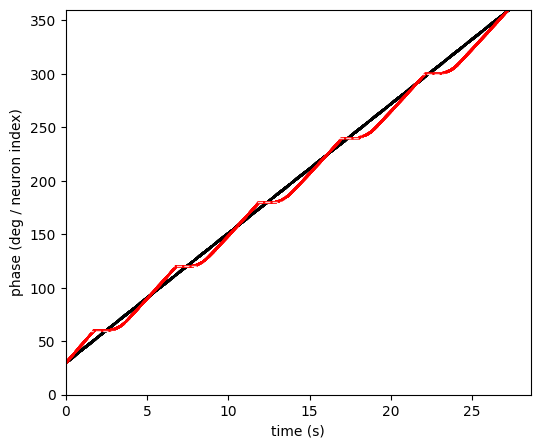

In [77]:
## wm= 0.0
plot_fig4c(
    net,
    sim,
    num_sim,
    init, initial_phase, end_phase,
    lm_locs,
    wolm_speed, wlm_speed, wm = 0.0)

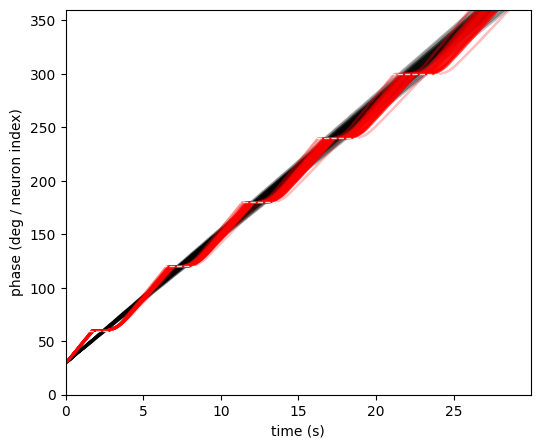

In [78]:
## wm= 0.02
plot_fig4c(
    net,
    sim,
    num_sim,
    init, initial_phase, end_phase,
    lm_locs,
    wolm_speed, wlm_speed, wm = 0.02)

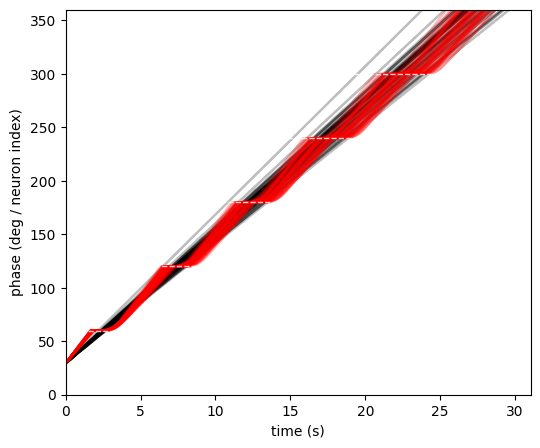

In [79]:
## wm= 0.05
plot_fig4c(
    net,
    sim,
    num_sim,
    init, initial_phase, end_phase,
    lm_locs,
    wolm_speed, wlm_speed, wm = 0.05)

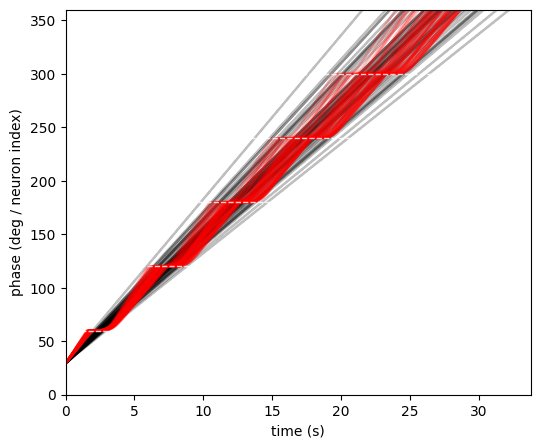

In [80]:
## wm= 0.08
plot_fig4c(
    net,
    sim,
    num_sim,
    init, initial_phase, end_phase,
    lm_locs,
    wolm_speed, wlm_speed, wm = 0.08)

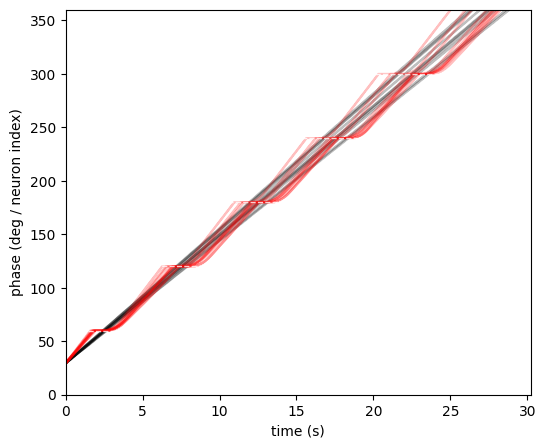

In [ ]:
lm_locs = np.arange(60, 301, 60)  
initial_phase = 30
end_phase = 360
num_sim = 10

K = 364
net = CANNetwork(K = K)
sim = CANSimulator(net)
init = sim.init_state(T=10)

wolm_speed = 0.45
wlm_speed = 0.65


## beware of extreme case (glitch near wrap zone?)
plot_fig4c(
    net,
    sim,
    num_sim,
    init, initial_phase, end_phase,
    lm_locs,
    wolm_speed, wlm_speed,
    #wolm_speed= 0.6, wlm_speed = 0.7,
    wm = 0.05)

In [61]:
# sanity check=??

def find_peaks_simple(x, min_distance=200, min_height=None):
    """
    Return indices of local maxima with a refractory period (min_distance).
    x: 1D array
    min_distance: in samples
    min_height: optional threshold
    """
    x = np.asarray(x)
    peaks = []
    last = -10**9
    for i in range(1, len(x)-1):
        if x[i] > x[i-1] and x[i] > x[i+1]:
            if min_height is not None and x[i] < min_height:
                continue
            if i - last < min_distance:
                # keep the taller peak within the refractory window
                if peaks and x[i] > x[peaks[-1]]:
                    peaks[-1] = i
                    last = i
                continue
            peaks.append(i)
            last = i
    return np.array(peaks, dtype=int)


def lm_periodicity_from_amp(out, dt, min_distance_steps=600):
    amp = out["lm_amplitude"]
    if np.all(amp == 0):
        return np.nan
    # threshold to ignore tiny numerical bumps
    thr = 0.2 * np.max(amp)
    pk = find_peaks_simple(amp, min_distance=min_distance_steps, min_height=thr)
    if len(pk) < 2:
        return np.nan
    return float(np.median(np.diff(pk)) * dt)

def grid_search_vlm_amp(sim, net, init, v_grid,
                        target_period=0.65,
                        num_trials=5,
                        T_max=8.0,
                        end_phase=600.0,
                        wm=0.0,
                        min_distance_steps=600,
                        **trial_kwargs):
    best = (None, np.inf, np.nan)
    for v in v_grid:
        periods = []
        for _ in range(num_trials):
            out = sim.run_trial(
                init_condition=init,
                landmarkpresent=True,
                wlm_speed=v, wolm_speed=v,
                wm=wm,
                T_max=T_max,
                end_phase=end_phase,
                **trial_kwargs
            )
            p = lm_periodicity_from_amp(out, net.dt, min_distance_steps=min_distance_steps)
            if np.isfinite(p):
                periods.append(p)

        if len(periods) == 0:
            print(f"v={v:.3f} -> no peaks")
            continue

        mean_p = float(np.mean(periods))
        err = abs(mean_p - target_period)
        print(f"v={v:.3f} -> period={mean_p:.3f}s err={err:.3f}s")

        if err < best[1]:
            best = (v, err, mean_p)

    return best


In [62]:
v_grid = np.linspace(0.1, 0.98, 16)   # widen if needed
best_vlm = grid_search_vlm_amp(sim, net, init, v_grid, target_period=0.65,
                               num_trials=3, T_max=8.0, end_phase=600.0,
                               landmark_input_loc=lm_locs,
                               landmark_onset_steps=500,   
                               landmark_tau_steps=1500,    
                               landmark_shift=3.0)
print("BEST VLM:", best_vlm)

v=0.100 -> no peaks
v=0.159 -> no peaks
v=0.217 -> no peaks
v=0.276 -> no peaks
v=0.335 -> no peaks
v=0.393 -> no peaks
v=0.452 -> no peaks
v=0.511 -> no peaks
v=0.569 -> period=5.364s err=4.714s
v=0.628 -> period=5.248s err=4.598s
v=0.687 -> period=4.864s err=4.213s
v=0.745 -> period=4.553s err=3.903s
v=0.804 -> period=4.271s err=3.621s
v=0.863 -> period=4.042s err=3.392s
v=0.921 -> period=3.932s err=3.282s
v=0.980 -> period=4.343s err=3.693s
BEST VLM: (np.float64(0.9213333333333333), 3.2824999999999998, 3.9324999999999997)


In [44]:
trial_lm = sim.run_trial(init_condition=init,
                            initial_phase=initial_phase,
                            end_phase=end_phase,
                            landmarkpresent=True,
                            landmark_input_loc=lm_locs,
                            wolm_speed=wolm_speed,
                            wlm_speed=0.85,
                            wm=0.0)
                            
phase = trial_lm["phase_unw"]
t = np.arange(len(phase)) * net.dt

delta = np.diff(phase)              # delta[k] = phase[k+1] - phase[k]
# indices of top 10 largest deltas
top_idx = np.argsort(delta)[-10:][::-1]

print("Top 10 phase jumps \n(delta\t\t time\t\t phase_before\t ->\t phase_after):")
for i in top_idx:
    print(f"Δ={delta[i]:6.1f}\t at t={t[i+1]:7.3f}s:\t {phase[i]:7.1f}\t ->\t {phase[i+1]:7.1f}")


Top 10 phase jumps 
(delta		 time		 phase_before	 ->	 phase_after):
Δ=   2.0	 at t=  0.104s:	    30.0	 ->	    32.0
Δ=   1.0	 at t= 21.201s:	   359.0	 ->	   360.0
Δ=   1.0	 at t=  4.506s:	   101.0	 ->	   102.0
Δ=   1.0	 at t=  3.149s:	    68.0	 ->	    69.0
Δ=   1.0	 at t=  7.608s:	   140.0	 ->	   141.0
Δ=   1.0	 at t= 14.633s:	   242.0	 ->	   243.0
Δ=   1.0	 at t= 16.662s:	   286.0	 ->	   287.0
Δ=   1.0	 at t=  3.712s:	    82.0	 ->	    83.0
Δ=   1.0	 at t= 16.918s:	   292.0	 ->	   293.0
Δ=   1.0	 at t= 15.985s:	   270.0	 ->	   271.0


“The CAN dynamics are simulated in discrete time steps; we calibrated the mapping from simulation steps to seconds by matching the model’s endogenous landmark periodicity to the task’s 0.65-s landmark spacing, as in the paper’s velocity calibration procedure.”

## Re-Tune wlm_speed and wolm_speed
The CAN evolves in phase units (which culd be neurons around the ring or degrees, depending on the preference).

We have seen from plasticity that internal landmarks were learned to be periodic in phase; so, to compare to our behavior and the specific navigation task, we need that periodicity to show up every $0.65s$ in time.

Need to tune the two base speeds so that:
- without landmarks: mean time to reach $360$ is $\sim 3.9$ / $4.0$
- with landmarks: mean time is similar too

*Remark*\
We need to separately tune $v_\text{LM}$ and $v_{\text{noLM}}$ because landmarks transiently 'stop the network' (produce a reset in phase shift). During those arrest/reset moments, the network makes less progress per unit time.

So if we ran simulations using the same baseline velocity in both models (with and without landmarks), the landmark model would take longer on average to reach the same final phase.

This explains why the authors used a higher baseline velocity for the landmark model:
- $v_\text{LM} = 0.42$ a.u.
- $v_{\text{noLM}} = 0.35$ a.u.

note that these values are written as arbitrary units and cannot be intended as a precise measure of distance traveled per unit time.

### With landmarks:
Time between landmark events is roughly $\Delta t \sim  \frac{\Delta \phi}{v}$, where $\Delta \phi$ is the distance (intended in terms of phase neurons), and $v$ is the drift velocity in phase / sec.

We hardcoded $\Delta \phi$ to be $60$ (degrees or neuron indices). Then matching $0.65s$ periodicity means choosing a velocity gain $v$ such that the network takes $\sim 0.65 s$ on average to advance by $60$ phase units in the landmark model.

The same reasoning holds if instead of having $\Delta \phi$ hardcoded, it came from the learned weights / preferred phases of the GC subset that provides $I_\text{int}$. In this casee, we can still do the same calibration, except $\Delta \phi$ is now whatever that learned periodicity is.

**Procedure**:
- run the LM model for a range of candidate speeds
- measure the average time between landmark reset events (or between plateau centers)
- pick the speed where that average is closest to 0.65 s

In [23]:
def mean_T_to_end(
    sim,
    init,
    landmarkpresent,
    wm,
    wlm_speed,
    wolm_speed,
    initial_phase=30,
    end_phase=360,
    n=20):
    Ts = []
    for _ in range(n):
        out = sim.run_trial(
            init_condition=init,
            initial_phase=initial_phase,
            end_phase=end_phase,
            landmarkpresent=landmarkpresent,
            landmark_input_loc=np.arange(60, 301, 60),
            wlm_speed=wlm_speed,
            wolm_speed=wolm_speed,
            wm=wm
        )
        phase = out['phase_unw']
        dphase = np.diff(phase)
        #print("max dphase:", dphase.max(), "min dphase:", dphase.min(), "any big jumps > 50?", np.any(dphase > 50))
        Ts.append((len(out["phase_unw"]) -1) * sim.network.dt)
    return float(np.mean(Ts)), float(np.std(Ts))

In [36]:
num_sim = 50
lm_locs = np.arange(60, 301, 60)  
initial_phase = 30
end_phase = 360

wm = 0.08
wolm_speed = 0.35
wlm_speed  = 0.42

#### Tune velocities wrt Final time (time to end)

In [58]:
def time_to_end(sim, init, v, wm, landmarkpresent, end_phase=360):
    out = sim.run_trial(init_condition=init, landmarkpresent=landmarkpresent, wm=0.0,
                        wolm_speed=v, wlm_speed=v, end_phase=end_phase, T_max=60,
                        landmark_onset_steps=200, landmark_tau_steps =150
    )
    return (len(out["phase_unw"]) - 1) * sim.network.dt


In [59]:
vels = np.linspace(0.1, 0.95, 20)
Ts = []
print('No lm')
for v in vels:
    T = time_to_end(sim, init, v, 0.0, False)
    Ts.append(T)
    print(f"v={v:.2f} -> T={T:.3f}s")

No lm
v=0.10 -> T=60.000s
v=0.14 -> T=60.000s
v=0.19 -> T=60.000s
v=0.23 -> T=52.568s
v=0.28 -> T=44.108s
v=0.32 -> T=38.042s
v=0.37 -> T=33.476s
v=0.41 -> T=29.910s
v=0.46 -> T=27.045s
v=0.50 -> T=24.689s
v=0.55 -> T=22.716s
v=0.59 -> T=21.040s
v=0.64 -> T=19.596s
v=0.68 -> T=18.341s
v=0.73 -> T=17.239s
v=0.77 -> T=16.262s
v=0.82 -> T=15.392s
v=0.86 -> T=14.611s
v=0.91 -> T=13.905s
v=0.95 -> T=13.265s


In [60]:
vels = np.linspace(0.1, 0.95, 20)
Ts = []
print('lm')
for v in vels:
    T = time_to_end(sim, init, v, 0.0, True)
    Ts.append(T)
    print(f"v={v:.2f} -> T={T:.3f}s")

lm
v=0.10 -> T=60.000s
v=0.14 -> T=60.000s
v=0.19 -> T=60.000s
v=0.23 -> T=52.681s
v=0.28 -> T=44.241s
v=0.32 -> T=38.190s
v=0.37 -> T=33.636s
v=0.41 -> T=30.080s
v=0.46 -> T=27.226s
v=0.50 -> T=24.884s
v=0.55 -> T=22.928s
v=0.59 -> T=21.269s
v=0.64 -> T=19.844s
v=0.68 -> T=18.610s
v=0.73 -> T=17.532s
v=0.77 -> T=16.579s
v=0.82 -> T=15.729s
v=0.86 -> T=14.969s
v=0.91 -> T=14.332s
v=0.95 -> T=13.530s


1. grid search the LM velocity so that the learned periodicity matches $0.65s$
2. under that optimal velocity -> measure distances at 0.65s and its multiples
3. do 5 separate noLM searches to find the nolm velocity that matches those distances

## time to intermediate landmarks

the paper’s velocity is in arbitrary units and they explicitly scale it for fair comparisons and do grid searches in that scaled space. 

So: you are allowed (and expected) to introduce a scaling constant between “task speed units” and “CAN modulation units”. That is not cheating; it’s exactly what they describe.

Concretely: you should treat beta_vel (or vel_gain) as a unit conversion knob, and search v over a much wider range while keeping the product beta_vel * vel_gain * v in a reasonable regime (<~1)

To match 0.65 s periodicity, you want time to advance one landmark spacing (≈60 phase units) to be ≈0.65 s.

That is:

slope
≈
60
0.65
≈
92.3
 phase-units/s
slope≈
0.65
60
	​

≈92.3 phase-units/s

So first measure your model’s mean phase slope (with landmarks on, because they tune the LM model periodicity first 

If your measured slope is way smaller, either:

- your velocity scaling is too weak (fixable via beta_vel or vel_gain), or

- your phase estimator is “lying” (common with multi-peak patterns + peak-following + jump clamping), or

- your connectivity asymmetry is too small (shift parameters in build_synapses), which truly caps maximum slope.

In [22]:
peak_init = int(np.argmax(init[:net.K]))
print("peak before run_trial alignment:", peak_init)

out = sim.run_trial(init_condition=init, landmarkpresent=False, wm=0.0)
print("phase start:", out["phase_unw"][0], "phase end:", out["phase_unw"][-1])
print("T:", (len(out["phase_unw"]) - 1) * net.dt)

peak before run_trial alignment: 94
phase start: 30.0 phase end: 360.0
T: 34.775


### Grid search v_LM using reset/landmark event times

- lm_entry_times[k] = step where landmark $k$ was first crossed
- peak of landmark happens at time lm_entry_times[k] + landmark_offset_steps

so reset time is (lm_entry_times[k] + landmark_offset_steps) * net.dt

and the periodicity is the mean difference between consecutive times

In [55]:
def lm_periodicity_seconds(out, dt = 1.0 / 2000.0, landmark_onset_steps= 500):
    lm_entry = out.get("lm_entry_times", None)
    if lm_entry is None:
        return np.nan
    lm_entry = lm_entry[~np.isnan(lm_entry)]
    if len(lm_entry) < 2:
        return np.nan
    reset_t = (lm_entry + landmark_onset_steps) * dt
    return float(np.mean(np.diff(reset_t)))

now grid-search

In [54]:
def grid_search_vlm(sim, net, init, v_grid, num_trials=10, target_period=0.65, **trial_kwargs):
    scores = []
    for v in v_grid:
        periods = []
        for _ in range(num_trials):
            out = sim.run_trial(
                init_condition=init,
                landmarkpresent=True,
                wlm_speed=v,
                wolm_speed=v,
                wm = 0.0,  
                **trial_kwargs
            )
            p = lm_periodicity_seconds(out, net.dt, trial_kwargs.get("landmark_onset_steps", 500))
            if not np.isnan(p):
                periods.append(p)
        if len(periods) == 0:
            scores.append((v, np.inf, np.nan))
            continue
        # mean periodicity
        mean_p = float(np.mean(periods))
        #error
        err = abs(mean_p - target_period)
        scores.append((v, err, mean_p))
    
    # sort them from lowest error to highest
    scores.sort(key=lambda x: x[1])
    return scores[0], scores  # (best_v, best_err, best_mean_period), all


In [56]:
scale = 3.91675 / 0.65
print("Suggested vel_gain scale:", scale)

net.vel_gain = scale

# re-init because changing velocity gain changes dynamics
sim = CANSimulator(net)
init = sim.init_state(T=10)

v_grid = np.linspace(0.1, 0.97, 18)
best = grid_search_vlm(sim, net, init, v_grid, target_period=0.65)
print("Best after scaling:", best)

Suggested vel_gain scale: 6.025769230769231


/Users/clara/Desktop/MAI/Anno 2/Sem 1/Neuro/Neupane Project/mental-navigation/src/mental_navigation/CAN/CAN_simulator.py:135: RuntimeWarning: overflow encountered in multiply
  G_R = v_R * (g_RL + g_RR + net.FF_global) + landmark_input
/Users/clara/Desktop/MAI/Anno 2/Sem 1/Neuro/Neupane Project/mental-navigation/src/mental_navigation/CAN/CAN_simulator.py:134: RuntimeWarning: overflow encountered in multiply
  G_L = v_L * (g_LL + g_LR + net.FF_global) + landmark_input


Best after scaling: ((np.float64(0.2023529411764706), 0.6475, 0.0025000000000000022), [(np.float64(0.2023529411764706), 0.6475, 0.0025000000000000022), (np.float64(0.3558823529411764), 0.6475, 0.0025000000000000022), (np.float64(0.1511764705882353), 3.304, 3.9539999999999997), (np.float64(0.1), 4.784125, 5.434125000000001), (np.float64(0.2535294117647059), inf, nan), (np.float64(0.30470588235294116), inf, nan), (np.float64(0.4070588235294118), inf, nan), (np.float64(0.4582352941176471), inf, nan), (np.float64(0.5094117647058823), inf, nan), (np.float64(0.5605882352941176), inf, nan), (np.float64(0.6117647058823529), inf, nan), (np.float64(0.6629411764705883), inf, nan), (np.float64(0.7141176470588235), inf, nan), (np.float64(0.7652941176470588), inf, nan), (np.float64(0.8164705882352942), inf, nan), (np.float64(0.8676470588235294), inf, nan), (np.float64(0.9188235294117647), inf, nan), (np.float64(0.97), inf, nan)])


In [82]:
K = 364
net = CANNetwork(K=K, beta_vel = 0.01, vel_gain=1.0)   # <- critical change
sim = CANSimulator(net)
init = sim.init_state(T=10)

lm_locs = np.arange(60, 301, 60)

# Step A must target ONLY 0.65 s
v_grid = np.linspace(10, 80, 15)   # velocities in "a.u."

best, scores = grid_search_vlm(
    sim, net, init,
    v_grid,
    num_trials=5,                  # start small
    target_period=0.65,
    landmark_onset_steps=500,
    landmark_input_loc=lm_locs,
    T_max=10.0,                    # keep short for search
    end_phase=360
)
print("best:", best)

best: (np.float64(80.0), 3.50925, 4.15925)


##

## Model with and without reset

In [22]:


target_T = 3.9  # seconds (so 360 happens within ~0-4s)

# start from baseline 
wlm, wolm = 0.42, 0.35
wm = 0.08

for it in range(10):
    T_nolm, _ = mean_T_to_end(sim, init, False, wm, wlm, wolm, n=10)
    scale = T_nolm / target_T
    wolm = wolm * scale   # if too slow (T_nolm > target_T), scale>1 increases wolm
    print(it, "T_noLM:", T_nolm, "new wolm:", wolm)

# now match LM mean time to noLM mean time by tuning wlm
T_goal, _ = mean_T_to_end(sim, init, False, wm, wlm, wolm, n=20)
for it in range(5):
    T_lm, _ = mean_T_to_end(sim, init, True, wm, wlm, wolm, n=10)
    scale = T_lm / T_goal
    wlm = wlm * scale
    print(it, "T_LM:", T_lm, "new wlm:", wlm)

print("Final tuned:", "wlm=", wlm, "wolm=", wolm)


0 T_noLM: 34.126700000000014 new wolm: 3.062652564102565
1 T_noLM: 0.0020000000000000005 new wolm: 0.0015705910585141363
2 T_noLM: 19.250499999999995 new wolm: 0.007752477736391377
3 T_noLM: 19.250499999999995 new wolm: 0.038266428888308245
4 T_noLM: 60.0 new wolm: 0.5887142905893576
5 T_noLM: 21.56805 new wolm: 3.2557485269604602
6 T_noLM: 0.0030499999999999998 new wolm: 0.002546162309546001
7 T_noLM: 19.250499999999995 new wolm: 0.012567922446132123
8 T_noLM: 19.3255 new wolm: 0.06227727826480163
9 T_noLM: 60.0 new wolm: 0.9581119733046405
10 T_noLM: 0.7467999999999999 new wolm: 0.1834661594010014
11 T_noLM: 60.0 new wolm: 2.8225562984769446
12 T_noLM: 0.0015 new wolm: 0.0010855985763372864
13 T_noLM: 19.250499999999995 new wolm: 0.005358542408661775
14 T_noLM: 19.250499999999995 new wolm: 0.026449902727677815
15 T_noLM: 60.0 new wolm: 0.40692158042581256
16 T_noLM: 28.785850000000003 new wolm: 3.003482968179584
17 T_noLM: 0.0017500000000000003 new wolm: 0.0013477167164908392
18 T_no

KeyboardInterrupt: 

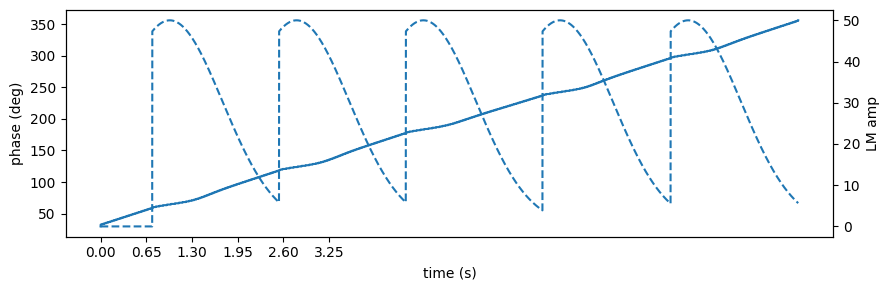

In [42]:
tr = tr_lm[0]
t = np.arange(len(tr["phase_unw"])) * net.dt
phase_deg = tr["phase_unw"] * (360.0/sim.network.K)

fig, ax1 = plt.subplots(figsize=(9,3))
ax1.plot(t, phase_deg)
ax1.set_ylabel("phase (deg)")
ax1.set_xlabel("time (s)")

ax2 = ax1.twinx()
ax2.plot(t, tr["lm_amplitude"], linestyle="--")
ax2.set_ylabel("LM amp")

ticks = np.arange(0, 3.25 + 1e-9, 0.65)
ax1.set_xticks(ticks)
ax1.set_xticklabels([f"{x:.2f}" for x in ticks])

plt.tight_layout()
plt.show()

### initial activity created
From the synaptic construction in CANNetwork, which mirrors Burak & Fiete (2009), the Left (L) and Right (R) populations are two copies of the same ring attractor. They are wired with slightly shifted recurrent connectivity in opposite directions.

As a result, their bumps are:
- identical in shape
- stable

but systematically phase-shifted with respect to each other. This allows velocity-driven motion of the bump.

#### Interpretation:
within-population connectivity:
- $L \leftarrow L$ connections are shifted by $+1$
- $R \leftarrow R$ onnections are shifted by $-1$

Cross-population connectivity:
- $L \leftarrow R$ and $R \leftarrow L$ are unshifted

It's like each ring wants to form a stable bump due to the Mexican-hat kernel, but the preferred alignment of that bump depends on how the kernel is shifted. This makes the two population bumps be slightly shifted in opposite directions. The two populations are always active together, and settle into a **consistent phase relationship**

Given:
- init_state
- parameters needed to create the landmark bump to inject
- params to initialize per-trial noisy velocity input



**clarifications**:
- the landmark gaussian has an amplitude amp(t) which is a gaussian in time. starts near 0 when we enter the region, grows to a peak and decays again with temporal scale tau
- landmark onset steps: when the bump phase crosses the landmark location, we say we enter the region of landmark. landmarl onset steps is the number of time steps taken after entering this region until reaching the peak in amplitude.

- landmark tau steps: the number of time steps taken for the amplitude to decay from the peak.\
    this means that internal landmarks are not an instantaneous kick, but a temporally extended boost around each learned phase.

    - if one unit step takes dt = 1/10 s -> landmark onset steps=500 means that 500 steps are required to reach the peak-> in seconds, 500*dt = 50


in each time step
- current velocity -> pick one noisy velocity per trial and keep it constant (using fine-tuned params by Neup&al)
- CAN dynamics: get current state and let the network evolve until phase threshold or time limit
- compute velocity biases
- compute recurrent synaptic inputs (recurrent contributions from the ring attractor)

- if we are at / near a landmark:
    - copute a landmark input bump and add it to both populations
- appply relu and update activity (euler step)
- stop when bump phase passes end_phase or when we hit time limit



tracking:
- nn_state: 1d list of bump center positions, written in terms of indices of ring neurons
- landmark bookkeeping:
    - lm_locs: ring neuron indices (phases) where learned landmarks live (list)
    - lm_flag: tells at which lm (lm k) we are in now (0 means none seen yet)
    - lm_times[k]: the time step when we first entered landmark region for landmark k

In [86]:
lm_locs = np.array([3.0, 7.0, 10.0])
phase = 2.0

last_lm_locs = [loc for loc in lm_locs if loc <= phase]
if last_lm_locs:
    last_lm_loc = last_lm_locs[-1]
    last_lm_idx = len(last_lm_locs)
else:
    last_lm_loc = None
    last_lm_idx = None


In [87]:
last_lm_locs, last_lm_idx

([], None)

In [67]:
K=10
ring = np.arange(0,10)
bump = np.array([3,7,6,3,4,3,4,5,6,3])
last_idx = 8
window = np.arange(last_idx-3, last_idx+4)
window_mod = window % K
bump_window = bump[window_mod]
idx_max_window = np.argmax(bump_window)
idx_max_ring = (last_idx-3+idx_max_window)%K

print(f'ring: {ring}')
print(f'bump: {bump}\n')
print(f'last_idx: {last_idx}, bump value: {bump[last_idx]}')
print(f'window: {window}')
print(f'window_mod: {window_mod}')
print(f'bump_window: {bump_window}')
print(f'idx_max_window: {idx_max_window}')
print(f'idx_max_ring: {idx_max_ring}')


ring: [0 1 2 3 4 5 6 7 8 9]
bump: [3 7 6 3 4 3 4 5 6 3]

last_idx: 8, bump value: 6
window: [ 5  6  7  8  9 10 11]
window_mod: [5 6 7 8 9 0 1]
bump_window: [3 4 5 6 3 3 7]
idx_max_window: 6
idx_max_ring: 1


In [49]:
len(bump)

9